$\newcommand{\vct}[1]{\boldsymbol{#1}}
\newcommand{\mtx}[1]{\mathbf{#1}}
\newcommand{\tr}{^\mathrm{T}}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\lpa}{\left(}
\newcommand{\rpa}{\right)}
\newcommand{\lsb}{\left[}
\newcommand{\rsb}{\right]}
\newcommand{\lbr}{\left\lbrace}
\newcommand{\rbr}{\right\rbrace}
\newcommand{\fset}[1]{\lbr #1 \rbr}
\newcommand{\pd}[2]{\frac{\partial #1}{\partial #2}}$

# Background

A neural network is composed of a number of layers, each implementing some transformation. The typical high level implementation of a single such layer (of basic type -> linear transformation plus non-linearity) can be formulated as follows:

\begin{equation}
    \vct{y} = \vct{f}(\mtx{W} \vct{x} + \vct{b})
    \qquad
    \Leftrightarrow
    \qquad
    y_k = f\lpa\sum_{d=1}^D \lpa W_{kd} x_d \rpa + b_k \rpa
\end{equation}

where $\mtx{W}$ and $\vct{b}$ parameterise an affine transformation, and $f$ is a function applied elementwise to the result of the affine transformation. For example a common choice for $f$ is the rectifier linear unit: 

\begin{equation}
  f(u) = max(0,u)
\end{equation}

One can stack an arbitrary number of such transformations, followed by an output layer. This means we can combine implementations of `AffineLayer` class with any non-linear function applied to the outputs just by implementing a layer object for the relevant non-linearity and then stacking the two layers together. 

To give a concrete example, in the `mlp.layers` module there is a definition for a `ReluLayer` equivalent to the following (documentation strings have been removed here for brevity)

```python
class ReluLayer(Layer):
    
    def fprop(self, inputs):
        return np.maximum(inputs, 0.)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        return (outputs > 0) * grads_wrt_outputs
```

As you can see this `ReluLayer` class has a very lightweight definition, defining just two key methods:

  * `fprop` which takes a batch of activations at the input to the layer and forward propagates them to produce activations at the outputs (directly equivalently to the `fprop` method of `AffineLayer`),
  * `brop` which takes a batch of gradients with respect to the outputs of the layer and back-propagates them to calculate gradients with respect to the inputs of the layer (explained in more detail below).
  
This `ReluLayer` class only implements the rectified linear transformation and so does not have any parameters. Therefore unlike `AffineLayer` it is derived directly from the base `Layer` class rather than `LayerWithParameters` and does not need to implement `grads_wrt_params` or `params` methods. 

To create a model consisting of an affine transformation followed by applying an elementwise rectified linear transformation you can first create a list of the two layer objects (in the order they are applied from inputs to outputs) and then use this to instantiate a new `MultipleLayerModel` object:

```python
from mlp.layers import AffineLayer, ReluLayer
from mlp.models import MultipleLayerModel

layers = [AffineLayer(input_dim, output_dim), ReluLayer()]
model = MultipleLayerModel(layers)
```

You can also stack an arbitrarily long sequence of layers together to produce deeper models. For instance the following would define a model consisting of three pairs of affine and rectified linear transformations.

```python
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim), ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim), ReluLayer(),
    AffineLayer(hidden_dim, output_dim), ReluLayer(),
])
```

## Back-propagation of gradients
 The `bprop` method takes gradients of an error function with respect to the *outputs* of a layer and uses these gradients to calculate gradients of the error function with respect to the *inputs* of a layer. As the inputs to a non-input layer in a multiple-layer model consist of the outputs of the previous layer, this means we can calculate the gradients of the error function with respect to the outputs of every layer in the model by iteratively propagating the gradients backwards through the layers of the model (i.e. from the last to first layer).

For a layer with parameters, the gradients with respect to the layer outputs are required to calculate gradients with respect to the layer parameters. Therefore by combining back-propagation of gradients through the model with computing the gradients with respect to parameters in the relevant layers one can calculate gradients of the error function with respect to all of the parameters of a multiple-layer model in a very efficient manner.

# Task 1: Exploring activation functions

Among other minor things, you are expected to implement the Exponential Linear Unit (ELU), Scaled Exponential Linear Unit (SELU), Gaussian Error Linear Unit (GELU), and the Inverse Square Root Linear Unit (ISRLU) layers (all in the mlp.layers module). Then run several basic experiments on the MNIST benchmark.

Below you are given basic blocks (how to build the model as a whole, define data providers, add optimiser, etc.) to get the whole training pipeline ready.

Your tasks here would be:

1-1) Add the missing layers mentioned above. Show how you arrived at the derivative of the GELU function (2-3 lines of the equation will suffice).

1-2) Establish a baseline network for MNIST using stochastic gradient descent (SGD) and the ReLU activation function. Explore the number of hidden units per layer, number of hidden layers, an appropriate learning rate and initialisation scale range and train for 100 epochs. Justify your choices.

1-3) Modify the baseline network to one that uses each of the above activation functions. Your main aim is to compare the generalization performance of each of these activation functions as well as discover the best possible network configuration when the only available options to choose from are the activation functions and their hyperparameters. Explain your findings.

1-4) Some of these activations have been shown to improve training when paired with special initialisation strategies. Investigate which of them do, implement them and rerun the corresponding optimal networks found in the previous excercise. Explain your findings. 

1-5) Select the optimal network from the exploration above. List possible improvements to the network to achieve better a) accuracy, b) training speed and c) inference speed. Implement one of each a) and b) and explain your observations (ie. did your hypothesis hold or not and why?).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from mlp.layers import AffineLayer, ReluLayer
from mlp.errors import CrossEntropyError, CrossEntropySoftmaxError
from mlp.models import SingleLayerModel, MultipleLayerModel
from mlp.initialisers import UniformInit, NormalInit, GlorotUniformInit, GlorotNormalInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')

# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', rng=rng)
valid_data = MNISTDataProvider('valid', rng=rng)
input_dim, output_dim = 784, 10

To minimise replication of code and allow you to run experiments more quickly a helper function is provided below which trains a model and plots the evolution of the error and classification accuracy of the model (on both training and validation sets) over training.

Running the cell below will create a model consisting of an affine layer followed by a softmax transformation and trains it on the MNIST data set by minimising the multi-class cross entropy error function using a basic gradient descent learning rule. By using the helper function defined below, at the end of the training curves of the evolution of the error function and also classification accuracy of the model over the training epochs will be plotted.

You should try running the code for various settings of the training hyperparameters defined at the beginning of the cell to get a feel for how these affect how training proceeds. You may wish to create multiple copies of the cell below to allow you to keep track of and compare the results across different hyperparameter settings.

In [2]:
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2


Below we describe how to build multiple-layer model architectures for the MNIST classification task. 

```python
layers = [
    AffineLayer(input_dim, 100),
    ReluLayer(),
    AffineLayer(100, output_dim),
    ReluLayer()
]
```

An example cell:

In [3]:
# disable logging by setting handler to dummy object
logger.handlers = [logging.NullHandler()]

--------------------------------------------------------------------------------
learning_rate=0.2 init_scale=0.1
--------------------------------------------------------------------------------


Experiment Progress: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


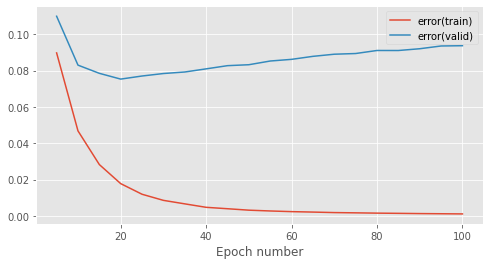

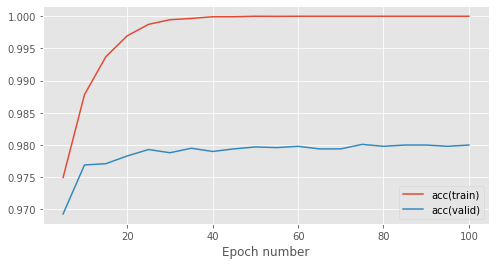

    final error(train) = 1.07e-03
    final error(valid) = 9.37e-02
    final acc(train)   = 1.00e+00
    final acc(valid)   = 9.80e-01
    run time per epoch = 1.73


In [4]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
learning_rate = 0.2  # learning rate for gradient descent

init_scales = [0.1]  # scale for random parameter initialisation
final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

# Initialisation Parmaeters
init_mean = 0.0
init_dev = 1.0

for init_scale in init_scales:

    print('-' * 80)
    print(f'learning_rate={learning_rate} init_scale={init_scale}')
    print('-' * 80)
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    # Alter data-provider batch size
    train_data.batch_size = batch_size 
    valid_data.batch_size = batch_size

    # Create a parameter initialiser which will sample random uniform values
    # from [-init_scale, init_scale]
    # param_init = UniformInit(-init_scale, init_scale, rng=rng)
    
    # Create a parameter initialiser which will sample random Normal ddistribution
    # having mean and standard deviation [init_mean, init_dev]
    # param_init = NormalInit(mean=init_mean, std=init_dev, rng=rng)

    # Create a parameter initialiser using Glorot Uniform model
    # param_init = GlorotUniformInit(rng=rng)

    # Create a parameter initialiser using Glorot Uniform model
    param_init = GlorotNormalInit(rng=rng)

    
    # Create a model with two affine layers
    hidden_dim = 100
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, param_init, param_init),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, param_init, param_init)
    ])

    # Initialise a cross entropy error object
    error = CrossEntropySoftmaxError()

    # Use a basic gradient descent learning rule
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)
    plt.show()

    print(f'    final error(train) = {stats[-1, keys["error(train)"]]:.2e}')
    print(f'    final error(valid) = {stats[-1, keys["error(valid)"]]:.2e}')
    print(f'    final acc(train)   = {stats[-1, keys["acc(train)"]]:.2e}')
    print(f'    final acc(valid)   = {stats[-1, keys["acc(valid)"]]:.2e}')
    print(f'    run time per epoch = {run_time * 1. / num_epochs:.2f}')

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])